### Dependencies
Here we import the modules and keys used in the program. 

In [325]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import gmaps
import os
import json
from scipy.stats import linregress

# Census & gmaps API Keys
from config import (weather_key, gkey)
# Configure gmaps
gmaps.configure(api_key=gkey)

### Data Sources
We use two data sources from openweather.com.  The weather data is extracted by calling the API, passing the a city id.  The list of cities for the different city id's is included in file `city.list.json`, which was downloaded separately from the website. We import the json data in the city list file to get the list of possible cities that can be queried via the API call (Over 200 thousand!). 
After importing the city.list.json file, we merge it with data imported from `country.codes.json`, another file downloaded from the web to obtain the full country name for every country code in the city.list.json file.

In [326]:
#Import Cities from file downloaded from openweather.com
filepath  = "city.list.json"
cities_pd = pd.read_json(filepath, encoding="utf-8")

# Import the country codes file to get the country names.
filepath = "countryCodes.json"
countryCodes = pd.read_json(filepath, orient="index", encoding="utf-8" )
countryCodes.index.rename("country", inplace=True)
countryCodes.columns=["Country Name"]

# Merge the city list with the country names data frames:
merged_data = cities_pd.merge(countryCodes, how="inner", on="country")
merged_data.head(10)

,id,name,state,country,coord,Country Name
0,833,Ḩeşār-e Sefīd,,IR,"{'lon': 47.159401, 'lat': 34.330502}","Iran, Islamic Republic Of"
1,3245,Taglag,,IR,"{'lon': 44.98333, 'lat': 38.450001}","Iran, Islamic Republic Of"
2,3530,Qabāghlū,,IR,"{'lon': 46.168499, 'lat': 36.173302}","Iran, Islamic Republic Of"
3,7264,Kalāteh-ye Dowlat,,IR,"{'lon': 57.616982, 'lat': 36.163841}","Iran, Islamic Republic Of"
4,8084,Behjatābād,,IR,"{'lon': 51.461639, 'lat': 36.667431}","Iran, Islamic Republic Of"
5,9874,Ţālesh Maḩalleh,,IR,"{'lon': 50.679192, 'lat': 36.894329}","Iran, Islamic Republic Of"
6,11263,Shahrīār Kandeh,,IR,"{'lon': 53.19902, 'lat': 36.631939}","Iran, Islamic Republic Of"
7,11754,Bālā Aḩmad Kolā,,IR,"{'lon': 52.667271, 'lat': 36.649059}","Iran, Islamic Republic Of"
8,14177,Āqdūz,,IR,"{'lon': 44.26556, 'lat': 39.197498}","Iran, Islamic Republic Of"
9,14256,Āzādshahr,,IR,"{'lon': 48.570728, 'lat': 34.790878}","Iran, Islamic Republic Of"


### Fetching weather data
Here we take a random sample of 600 cities from the merged city data frame and for each one, invoke the `openweather` API service, passing in the city id as parameter.  We extract the latitute, longitude, temperature, humidity, cloudiness % and wind speed for each city and add each record to a list of weather data, that will be used in subsequent steps to produce analysis.

In [327]:
base_url = "https://api.openweathermap.org/data/2.5/weather?"
params = {"appid": weather_key,
          "units": "imperial"}

# Sample 600 cities and get their weather info
cities = merged_data.loc[:,["id", "name", "Country Name"]].sample(600)

# Save each city's information in a list of dictionaries

weather_data = []

for ind in cities.index:
    print("Fetching weather for city: " , cities["name"][ind] , " in " , cities["Country Name"][ind],"...")
    params["id"] = cities["id"][ind]
    city_weather = requests.get(base_url, params=params).json()
    weather_data.append({
                     "City ID"    : cities["id"][ind],
                     "Lat"        : city_weather["coord"]["lat"],
                     "Lon"        : city_weather["coord"]["lon"],
                     "Temp"       : city_weather["main"]["temp"],
                     "Humidity"   : city_weather["main"]["humidity"],
                     "Cloudiness" : city_weather["clouds"]["all"],
                     "Wind Speed" : city_weather["wind"]["speed"]
                    })

city:  Chonggang  in  China ...
Fetching weather for city:  Rumersheim-le-Haut  in  France ...
Fetching weather for city:  Howland  in  United States ...
Fetching weather for city:  Saxony-Anhalt  in  Germany ...
Fetching weather for city:  Olula del Río  in  Spain ...
Fetching weather for city:  Bijāwar  in  India ...
Fetching weather for city:  Dalkey  in  Ireland ...
Fetching weather for city:  Sung Men  in  Thailand ...
Fetching weather for city:  Wawern  in  Germany ...
Fetching weather for city:  Lorena  in  United States ...
Fetching weather for city:  Kedungbanteng Krajan  in  Indonesia ...
Fetching weather for city:  Hockinson  in  United States ...
Fetching weather for city:  Uchte  in  Germany ...
Fetching weather for city:  Cleland  in  United Kingdom ...
Fetching weather for city:  Al Ittiḩād  in  Palestinian Territory, Occupied ...
Fetching weather for city:  Manerba del Garda  in  Italy ...
Fetching weather for city:  Hå  in  Norway ...
Fetching weather for city:  Blofel

### Save weather data to a file
We then convert the `weather_data[]` list to a Pandas DataFrame, and save it to a local `*.csv` file. 

In [328]:
#Create a data frame for the data and save to CSV file
weather_df = pd.DataFrame(weather_data)
weather_df = weather_df.set_index("City ID")
weather_df.to_csv("weather_data.csv")
weather_df.head(10)


,Lat,Lon,Temp,Humidity,Cloudiness,Wind Speed
City ID,,,,,,
4736420,30.3480,-97.9850,64.49,29,1,6.91
492821,53.0244,34.4392,18.00,97,100,8.88
6360495,41.0457,-5.2677,47.71,87,75,19.57
3064143,49.4308,17.2880,19.76,85,64,1.99
2775819,48.4834,13.8096,27.00,94,75,3.18
6360685,43.1079,-3.8906,58.66,63,20,24.16
616488,40.5176,44.9319,32.00,93,75,2.30
602426,63.8333,20.4833,1.40,92,90,3.44
935085,-26.0000,31.5000,78.01,93,100,3.44


## Weather Data Analysis
In this section, we create scatter plots using `matplotlib` based on the weather data.
The first chart compares the temperature with the latitude for each of the 600 cities in the sample.

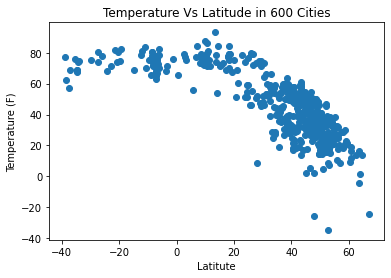

In [329]:
# Plot out temperatur versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Temp']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Temperature (F)')
plt.title("Temperature Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("01_Temp_Vs_Latitudes.png")
plt.show()


The graph shows a moderate to strong negative correlation between latitude and temperature, that is, temperatures tend to be lower at higher (absolute) latitute values.  For cities in the southern hemisphere, the temperatures are much higer than for northen temperatures.  This is because the weather data was obtained during the summer season of the southern hemisphere.

Also, note that there are much more cities in the northen hemisphere than in the southern latitutes, this could be a result of the random selection picking more cities in the northen latitudes, or it could be that there are actually more cities in the north hemisphere than in the south.

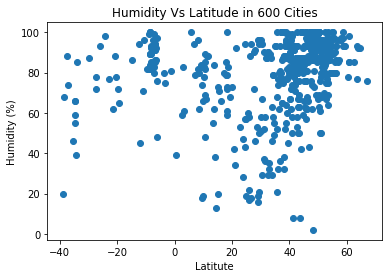

In [330]:
# Plot out humidity versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Humidity']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Humidity (%)')
plt.title("Humidity Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("02_Humidity_Vs_Latitudes.png")
plt.show()

Here we compare the humidity % to the city's latitude.  It is clear that, at this time, humidity is higher in the higher latitudes. Again, the graph shows there are less data points for the southern latitudes. 

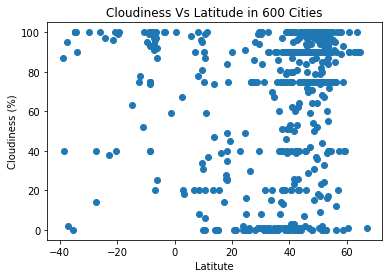

In [331]:
# Plot out Cloudiness versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Cloudiness']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Cloudiness (%)')
plt.title("Cloudiness Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("03_Cloudiness_Vs_Latitudes.png")
plt.show()

Cloudiness Vs Latitude does not show a pattern, as the data points are spread throughout the whole chart.  You could say that southern latitutes are less cloudy, but that could be caused by the selection of cities picking up more cities in the northen latitudes. 

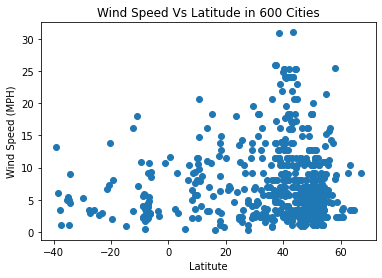

In [332]:
# Plot out Wind Speed versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Wind Speed']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Wind Speed (MPH)')
plt.title("Wind Speed Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("04_Wind_Speed_Vs_Latitudes.png")
plt.show()

Comparing wind speed values with the latitude, higher values are observed for higher latitudes.

---

## Southern vs. Norhten Hemispheres Analysis
In this section, we perform the same comparisons as before (Temperature, Wind Speed, Humidity and Cloudiness), but we separate the data points as coming from cities in the northen hemisphere (Latitudes > 0) and shouthern hemisphere (Latitude < 0).  Remember the data was obtained on January 2021, when it was winter in the northern latitudes and summer in the southern ones.
The steps to create these charts are:

1. Create figure with 2 subplots in matlibplot.
2. Create a dataframe for positive latitudes from the weather data (northern hemisphere)
3. Create a dataframe for negative latitudes from the weather data (souther hemisphere)
4. Run linear regression on each latitute - weather parameter (temp, wind, etc.)
5. Plot a scatter plot for the northen latitudes and another one for the southern latitudes, including the regression line.

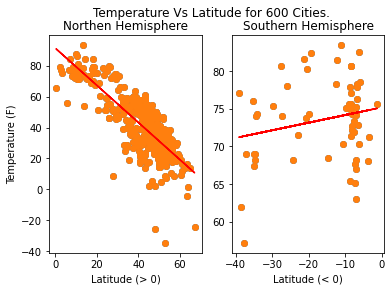

In [333]:
# Separate the weather_df data frame , creating two additional ones for each hemisphere.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Temperature Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]


# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Temp']

(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")

ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Temperature (F)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities

#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Temp']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("05_Temp_Vs_Latitudes_Multi.png")
fig.show()


For the northen hemisphere, it clear there is a strong negative correlation between temperature and latitude.  The correlation is not so obvious for the southern hemisphere, as a weak positive correlation is seen (higher temperatures are also found closer to the equator), but the temperature distribution is more spread than in the northen latitudes.

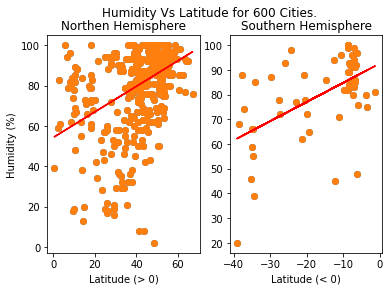

In [334]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Humidity Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]

# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Humidity']

(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")

ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Humidity (%)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities
#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Humidity']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("06_Humid_Vs_Latitudes_Multi.png")
fig.show()

Here we create the same scatter plots, but the paramter analyzed is Humidity %.  Both hemispheres show a positive correlation.  For the norhthen hemisphere this means humidity is greater at higher latitudes, and for the southern hemisphere, the humidity is greater closer to the equator. 

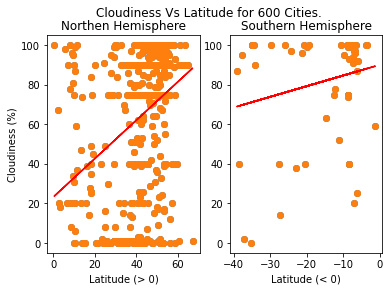

In [335]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Cloudiness Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]

# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Cloudiness']


(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")


ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Cloudiness (%)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities
#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Cloudiness']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("07_Cloud_Vs_Latitudes_Multi.png")
fig.show()

The cloudiness distribution really shows no definitive pattern, althouth the regresion values indicate a positive correlation between cloudiness % and latitude.  This would suggest that the higher the latitude, the cloudier it gets. 

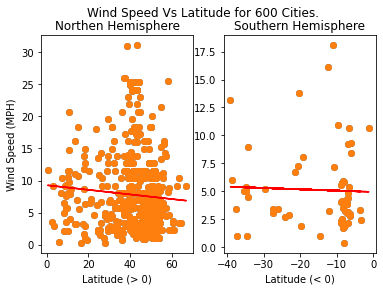

In [336]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Wind Speed Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]

# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Wind Speed']

(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")

ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Wind Speed (MPH)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities
#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Wind Speed']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("08_Wind_Vs_Latitudes_Multi.png")
fig.show()

Wind speed analysis shows an increase in wind speed as we get closer to the equator for the northen hemispheres, and a small decrease in wind speed as we get closer to the equator in the southern hemisphere.  